# Import Libraries

In [58]:
from datetime import datetime #keep track of when code runs
import pandas as pd #use to manipulate data like spreadsheet
import numpy as np #use math/numerical functions to apply to data
import matplotlib.pyplot as plt #use to visualize/graph data
from matplotlib.gridspec import GridSpec 
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import pathlib #Create directory for where files will be saved
import io #save graph/figure as image
import docx #use to insert image into word document
from docx.shared import Pt, Cm, Inches
from docx.enum.dml import MSO_THEME_COLOR_INDEX

In [59]:
print('Started at {}'.format(datetime.now()))

Started at 2022-02-07 15:24:53.230007


# Import MAP Data

In [60]:
window = 'MOY_21_22'
date='02_02_2022' #Previous Day - i.e. last full day of complete results
growth_term = 'FallToWinter'

filepath = r'C:\Users\SHICKEY\OneDrive - Dallas Independent School District\MAP_Combined_Data\{}\AssessmentResults_{}.csv'.format(window, date)

nwea = pd.read_csv(filepath)
nwea.shape

filepath_students = r'C:\Users\SHICKEY\OneDrive - Dallas Independent School District\MAP_Combined_Data\{}\StudentsBySchool_{}.csv'.format(window, date)

students = pd.read_csv(filepath_students)
students = students[['StudentID', 'Grade']]

nwea = nwea.merge(students, on='StudentID', how='left')

C:\Users\SHICKEY\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (53,56) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Clean data

In [61]:
''' 
Remove / from school names
'''

nwea['SchoolName'] = nwea['SchoolName'].str.replace('/', '-') 

nwea_schools = nwea[['School_StateID', 'SchoolName']]
nwea_schools = nwea_schools.drop_duplicates()
    
'''
Convert grade to string, remove K and 12 from dataset, convert back to int
'''

nwea['Grade'] = nwea['Grade'].astype(str)
nwea = nwea[(nwea['Grade'] != 'K') & (nwea['Grade'] != '12')] 
nwea['Grade'] = nwea['Grade'].astype(int)
# nwea['Grade'] = pd.Categorical(nwea['Grade'],['K','1','2','3','4','5','6','7','8','9','10','11'], ordered=True)
nwea['Grade'].dtypes

'''
Slice dataset - Select the desired columns for the dataset
''' 

nwea = nwea[['SchoolName','School_StateID','StudentID','Grade','Subject', 'Course','TestName', 
             'TestRITScore','TestStandardError','TestPercentile','AchievementQuintile',
             '{}ProjectedGrowth'.format(growth_term),'{}ObservedGrowth'.format(growth_term),'{}ObservedGrowthSE'.format(growth_term),'{}MetProjectedGrowth'.format(growth_term),
             '{}ConditionalGrowthIndex'.format(growth_term), '{}ConditionalGrowthPercentile'.format(growth_term),'{}GrowthQuintile'.format(growth_term),
             'ProjectedProficiencyStudy1','ProjectedProficiencyLevel1','ProjectedProficiencyStudy4','ProjectedProficiencyLevel4']]

''' 
Create list of tested schools to use for onepagers
'''
tested_schools = sorted(list(nwea['SchoolName'].unique())) #List of all Schools

In [62]:
#Delete this cell -- This was used for sample data
school_1 = tested_schools[217]
school_2 = tested_schools[213]
school_3 = tested_schools[23]
tested_schools = [school_1, school_2, school_3]

## Import Completion File from MAPDailyEnrollment Python File - MAPEnrollmentTables

In [63]:
completion = pd.read_csv('C:/Users/SHICKEY/OneDrive - Dallas Independent School District/MAP_Reports/map_completion_{}.csv'.format(date))
completion = completion.sort_values(['SchoolName','Grade'])
completion['SchoolName'] = completion['SchoolName'].str.replace('/', '-')

# Data Manipulation: Create Summary Table for Every Testing Area
Table includes achievement data, growth data, staar data, and ACT data

In [64]:
def map_summary(course_name):
    nwea_subject = nwea[nwea['Course'] == course_name]
   
    '''
    Create a column for each quintile, include the number of students in quintile in each grade
    '''
    # --------------------------------------------- Achivement -----------------------------------------------------------------------#
    quintile_list = list(nwea_subject['AchievementQuintile'].unique())
    quintile_list = ['Low','LoAvg', 'Avg', 'HiAvg',  'High']

    group_quintile_list = []
    
    #Makes list of columns with N of Students for each quintile
    for quintile in quintile_list:
        group_quintile = nwea_subject[nwea_subject['AchievementQuintile'] == quintile]
        group_quintile = group_quintile.groupby(['SchoolName','Grade']).agg({'AchievementQuintile' : 'count'})
        group_quintile_list.append(group_quintile)

    #Concatenate list of columns into a dataframe
    school_quintiles = pd.concat([df for df in group_quintile_list], ignore_index=False, axis=1)
    school_quintiles.columns = quintile_list

    # ---------------------------------------------- STAAR ---------------------------------------------------------------------#
    staar_list = ['Did not Meet','Approaches', 'Meets','Masters']
    group_staar_list = []

    #Makes list of columns with N of Students for each quintile
    for staar in staar_list:
        group_staar = nwea_subject[nwea_subject['ProjectedProficiencyLevel4'] == staar]
        group_staar = group_staar.groupby(['SchoolName','Grade']).agg({'ProjectedProficiencyLevel4' : 'count'})
        group_staar_list.append(group_staar)

    #Concatenate list of columns into a dataframe
    school_staar = pd.concat([df for df in group_staar_list], ignore_index=False, axis=1)
    school_staar.columns = staar_list
    
    # ------------------------------------------------- ACT -------------------------------------------------------------------#
    act_list = ['Not On Track', 'On Track 22','On Track 24']
    group_act_list = []
    
    #Makes list of columns with N of Students for each quintile
    for act in act_list:
        group_act = nwea_subject[nwea_subject['ProjectedProficiencyLevel1'] == act]
        group_act = group_act.groupby(['SchoolName','Grade']).agg({'ProjectedProficiencyLevel1' : 'count'})
        group_act_list.append(group_act)

    #Concatenate list of columns into a dataframe
    school_act = pd.concat([df for df in group_act_list], ignore_index=False, axis=1)
    school_act.columns = ['<22', '22-24', '>24']

    # -------------------------------------------- Growth if not Spanish --------------------------------------------------#
    if course_name != 'Reading (Spanish)':
        nwea_subject_growth = nwea_subject.dropna(subset=['{}GrowthQuintile'.format(growth_term)])

        growth_quintile_list = ['Low Growth','LoAvg Growth', 'Avg Growth', 'HiAvg Growth',  'High Growth']

        group_growth_quintile_list = []

        #Makes list of columns with N of Students for each quintile
        for growth_quintile in quintile_list:
            group_growth_quintile = nwea_subject_growth[nwea_subject_growth['{}GrowthQuintile'.format(growth_term)] == growth_quintile]
            group_growth_quintile = group_growth_quintile.groupby(['SchoolName','Grade']).agg({'{}GrowthQuintile'.format(growth_term) : 'count'})
            group_growth_quintile_list.append(group_growth_quintile)

        #Concatenate list of columns into a dataframe
        school_growth_quintiles = pd.concat([df for df in group_growth_quintile_list], ignore_index=False, axis=1)
        school_growth_quintiles.columns = growth_quintile_list

        # --------------------------------------------------------------------------------------------------------------------#
        '''
        Merge all table subsets together into one table for non-Spanish tests
        ''' 
        map_summary = pd.merge(school_quintiles, school_staar, left_index=True, right_index=True, how='outer')
        map_summary = pd.merge(map_summary, school_growth_quintiles, left_index=True, right_index=True, how='outer')
        map_summary = pd.merge(map_summary, school_act, left_index=True, right_index=True, how='outer')
        map_summary = map_summary.astype('Int64')

        return map_summary
       
        '''
        Merge all table subsets (without growth) together into one table for Spanish tests
        ''' 
    else:
        map_summary = pd.merge(school_quintiles, school_staar, left_index=True, right_index=True, how='outer')
        map_summary = map_summary.astype('Int64')
        map_summary = pd.merge(map_summary, school_act, left_index=True, right_index=True, how='outer')
        return map_summary

In [65]:
map_summary_read = map_summary('Reading')
map_summary_read_spa = map_summary('Reading (Spanish)')
map_summary_math = map_summary('Math K-12')
map_summary_sci = map_summary('Science K-12')

#### https://stackoverflow.com/questions/60250912/filter-dataframe-with-multiindex-by-specific-index-value

# Quintiles
##### Low = 0-20
##### LoAvg = 21-40
##### Avg = 41-60
##### HiAvg = 61-80
##### High = 81-100

In [66]:
#Greens: #21b876 #1fa36a #3ab07d #47ba88 #42bd79 #53c988 #70d473 #8dd98f
#Blues: #6d8dbd #346094 #486ca3 #5f97c2 #70a9d4
#District Red: '#ED1E23'

In [67]:
def image2file(image):
    """Return `image` as PNG file-like object."""
    image_file = io.BytesIO()
    image.savefig(image_file, format="PNG")
    return image_file

# Print OnePager for Each School

1 ES School Name = Complete
2 MS School Name = Complete
3 HS School Name = Complete
All Schools Complete
Wall time: 2.33 s


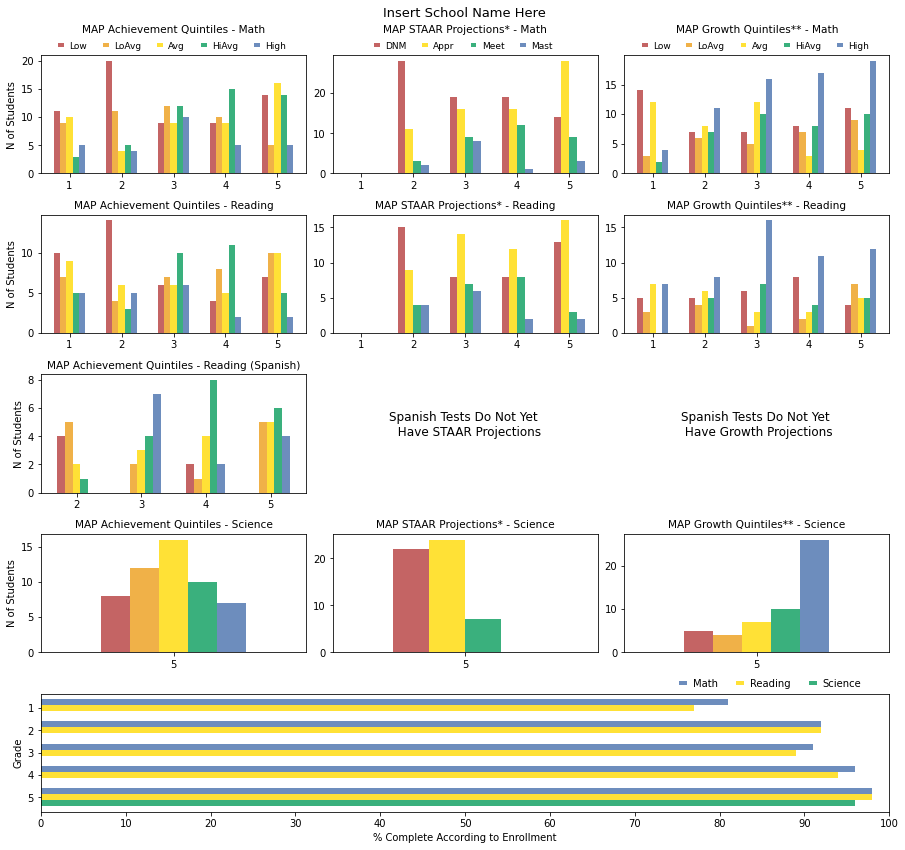

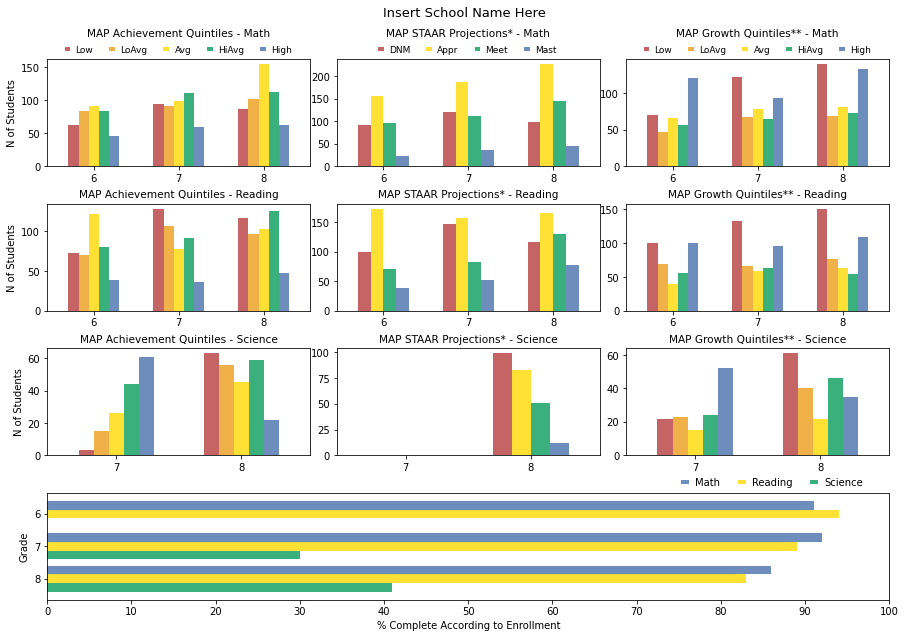

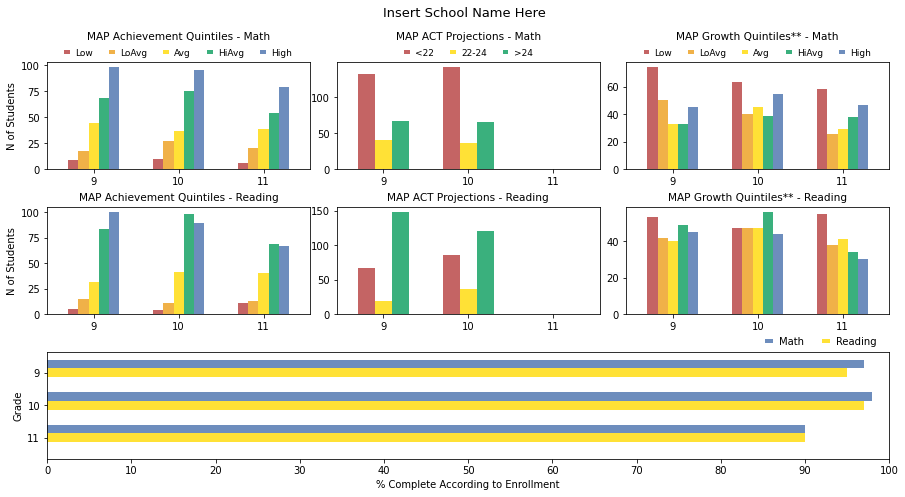

In [68]:
%%time
import pathlib
from matplotlib.lines import Line2D

width = 7
height = 6.5
hs_height = 5
top = 1.1
bottom = 1.1
left = 1.6
right = 1.5
paragraph_size = 10

c=0
for test_school in tested_schools:
    #--------------------------------------------------------------------------------------------------------#
    colors = ['#c46464', '#f0b148', '#ffe136', '#3ab07d', '#6d8dbd']  #f5e542 
    staar_colors = ['#c46464', '#ffe136', '#3ab07d', '#6d8dbd']
    bar_width = 0.6
    completion_bar_width = 0.8
    #--------------------------------------------------------------------------------------------------------#
    math_school = map_summary_math[map_summary_math.index.get_level_values(0) == test_school]
    read_school = map_summary_read[map_summary_read.index.get_level_values(0) == test_school]
    read_spa_school = map_summary_read_spa[map_summary_read_spa.index.get_level_values(0) == test_school]
    sci_school = map_summary_sci[map_summary_sci.index.get_level_values(0) == test_school]

    es_list = [1, 2, 3, 4, 5]
    ms_list = [6, 7, 8]
    
    '''
    Select subset of data from table (i.e. quintiles) so that it can be plotted - drop schoolname so grade level is accessible
    '''

    math_quintiles = math_school.loc[:,'Low':'High'].droplevel('SchoolName')
    math_staar = math_school.loc[:,'Did not Meet':'Masters'].droplevel('SchoolName')
    math_growth_quintiles = math_school.loc[:,'Low Growth':'High Growth'].droplevel('SchoolName')
    math_act = math_school.loc[:,'<22':'>24'].droplevel('SchoolName')

    read_spa_quintiles = read_spa_school.loc[:,'Low':'High'].droplevel('SchoolName')
    read_spa_staar = read_spa_school.loc[:,'Did not Meet':'Masters'].droplevel('SchoolName')

    read_quintiles = read_school.loc[:,'Low':'High'].droplevel('SchoolName')
    read_staar = read_school.loc[:,'Did not Meet':'Masters'].droplevel('SchoolName')
    read_growth_quintiles = read_school.loc[:,'Low Growth':'High Growth'].droplevel('SchoolName')
    read_act = read_school.loc[:,'<22':'>24'].droplevel('SchoolName')

    sci_quintiles = sci_school.loc[:,'Low':'High'].droplevel('SchoolName')
    sci_staar = sci_school.loc[:,'Did not Meet':'Masters'].droplevel('SchoolName')
    sci_growth_quintiles = sci_school.loc[:,'Low Growth':'High Growth'].droplevel('SchoolName')

    #Create Completion Table, Create new Directory for Each Director
    completion_school = completion[completion['SchoolName'] == test_school]
    
    '''
    Select subset of completion table, extract director name from completion table, create new folder for each director if doesn't exist already
    '''
    
    if len(completion_school.index) != 0: #If school shows up in completion report AND in NWEA (Joined on NWEA school code)
        director = completion_school['Executive Director'].iloc[0] #Set director name equal to director
        director = director.replace(',','')
    else: #If school does not show up in completion report, but does show up in NWEA
        director = 'NoED' #set director = NoED
    
    ############## Create a new directory/folder for each director inside the EDs Folder #######################
    # pathlib.Path(r"C:\Users\SHICKEY\OneDrive - Dallas Independent School District\MAP_Reports\SchoolSummary_EDs_{}\{}".format(date, director)).mkdir(parents=True, exist_ok=True)
    pathlib.Path(r"G:\My Drive\InterventionistCampusOnePagers_{}\{}".format(date,test_school)).mkdir(parents=True, exist_ok=True)

    completion_school = completion_school[['Grade','Math %', 'Reading %', 'Science %']]
    completion_school = completion_school.set_index('Grade')

    #-------------------- Make plots for all areas -----------------------------------------------------#

    ###################### Elementary Schools ##############################

    #If school has any elementary school grade (1-5), continue
    if (math_school.index.isin(es_list, level='Grade').any() == True) | \
        (read_school.index.isin(es_list, level='Grade').any() == True) | \
        (read_spa_school.index.isin(es_list, level='Grade').any() == True) | \
        (sci_school.index.isin(es_list, level='Grade').any() == True):

        fig = plt.figure(figsize=(13,12))
        fig.suptitle('Insert School Name Here', fontsize=13, y=0.98) #test_school

        gs=GridSpec(5,3) # 2 rows, 3 columns

        ax00 =fig.add_subplot(gs[0,0]) # First row, first column
        ax01 =fig.add_subplot(gs[0,1]) # First row, second column
        ax02 =fig.add_subplot(gs[0,2]) # First row, third column

        ax10 =fig.add_subplot(gs[1,0]) # Second row, first column
        ax11 =fig.add_subplot(gs[1,1]) # Second row, second column
        ax12 =fig.add_subplot(gs[1,2]) # Second row, third column

        ax20 =fig.add_subplot(gs[2,0]) # Third row, first column
        ax21 =fig.add_subplot(gs[2,1]) # Third row, second column
        ax22 =fig.add_subplot(gs[2,2]) # Third row, third column

        ax30 =fig.add_subplot(gs[3,0]) # Fourth row, first column
        ax31 =fig.add_subplot(gs[3,1]) # Fourth row, second column
        ax32 =fig.add_subplot(gs[3,2]) # Fourth row, third column

        ax4 =fig.add_subplot(gs[4,:]) # Fifth row, span all columns

        if len(math_school.index) != 0:
            math_quintiles.plot(kind='bar', ax=ax00, title='MAP Achievement Quintiles - Math', color=colors, width=bar_width)
            math_staar.plot(kind='bar', ax=ax01, title='MAP STAAR Projections* - Math', color=staar_colors, width=bar_width)
            math_growth_quintiles.plot(kind='bar', ax=ax02, title='MAP Growth Quintiles** - Math', color=colors, width=bar_width)

        if len(read_school.index) != 0:
            read_quintiles.plot(kind='bar', ax=ax10, title='MAP Achievement Quintiles - Reading', color=colors, legend = None, width=bar_width)
            read_staar.plot(kind='bar', ax=ax11, title='MAP STAAR Projections* - Reading', color=staar_colors, legend = None, width=bar_width)
            read_growth_quintiles.plot(kind='bar', ax=ax12, title='MAP Growth Quintiles** - Reading', color=colors, legend = None, width=bar_width)

        if len(read_spa_school.index) != 0:
            read_spa_quintiles.plot(kind='bar', ax=ax20, title='MAP Achievement Quintiles - Reading (Spanish)', color=colors, legend = None, width=bar_width)
            read_spa_staar.plot(kind='bar', ax=ax21, title='', color=['tab:red', 'gold', 'tab:green', 'tab:blue'], legend = None, width=bar_width)

        if len(sci_school.index) != 0:
            sci_quintiles.plot(kind='bar', ax=ax30, title='MAP Achievement Quintiles - Science', color=colors, legend = None, width=bar_width)
            sci_staar.plot(kind='bar', ax=ax31, title='MAP STAAR Projections* - Science', color=staar_colors, legend = None, width=bar_width)
            sci_growth_quintiles.plot(kind='bar', ax=ax32, title='MAP Growth Quintiles** - Science', color=colors, legend = None, width=bar_width) #use for MOY and EOY only

        if len(completion_school.index) != 0:
            completion_school.plot(kind='barh', ax=ax4, color=['#6d8dbd', '#ffe136', '#3ab07d'], width=completion_bar_width)

        #--------------------------------------------------------------------------------------------------------#
        ax00.set_ylabel('N of Students')
        ax10.set_ylabel('N of Students')
        ax20.set_ylabel('N of Students')
        ax30.set_ylabel('N of Students')
        ax4.invert_yaxis()

        #Remove x axis labels for plots
        ax00.set_xlabel('') 
        ax01.set_xlabel('') 
        ax02.set_xlabel('') 
        ax10.set_xlabel('') 
        ax11.set_xlabel('') 
        ax12.set_xlabel('') 
        ax20.set_xlabel('') 
        ax21.set_xlabel('') 
        ax22.set_xlabel('') 
        ax30.set_xlabel('') 
        ax31.set_xlabel('') 
        ax32.set_xlabel('') 
        ax4.set_xlabel('% Complete According to Enrollment')

        ax00.tick_params(axis='x', rotation=0) 
        ax01.tick_params(axis='x', rotation=0) 
        ax02.tick_params(axis='x', rotation=0)

        ax10.tick_params(axis='x', rotation=0)
        ax11.tick_params(axis='x', rotation=0) 
        ax12.tick_params(axis='x', rotation=0) 

        ax20.tick_params(axis='x', rotation=0) 
        ax21.tick_params(axis='x', rotation=0) 
        ax22.tick_params(axis='x', rotation=0) 

        ax30.tick_params(axis='x', rotation=0) 
        ax31.tick_params(axis='x', rotation=0)
        ax32.tick_params(axis='x', rotation=0)


        ax4.xaxis.set_ticks(np.arange(0, 101, 10))
        ax4.set_xlim([0, 100])

        #--------------------------------------------------------------------------------------------------------#

        ax00.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax01.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax02.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        ax10.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax11.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax12.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        ax20.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax21.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax22.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        ax30.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax31.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax32.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        #--------------------------------------------------------------------------------------------------------#

        ax00.set_title('MAP Achievement Quintiles - Math', size=10.5, y=1.0, pad=23) 
        ax01.set_title('MAP STAAR Projections* - Math', size=10.5, y=1.0, pad=23) 
        ax02.set_title('MAP Growth Quintiles** - Math', size=10.5, y=1.0, pad=23) 

        ax10.set_title('MAP Achievement Quintiles - Reading', size=10.5) 
        ax11.set_title('MAP STAAR Projections* - Reading', size=10.5) 
        ax12.set_title('MAP Growth Quintiles** - Reading', size=10.5) 

        ax20.set_title('MAP Achievement Quintiles - Reading (Spanish)', size=10.5) 
        ax21.set_title('Spanish Tests Do Not Yet \n  Have STAAR Projections', y=0.6, pad=-14)
        ax21.axis('off')
        ax22.set_title('Spanish Tests Do Not Yet \n Have Growth Projections', y=0.6, pad=-14)
        ax22.axis('off')

        ax30.set_title('MAP Achievement Quintiles - Science', size=10.5)
        ax31.set_title('MAP STAAR Projections* - Science', size=10.5)
        ax32.set_title('MAP Growth Quintiles** - Science', size=10.5)

        #--------------------------------------------------------------------------------------------------------#

        #Create custom legends for first three plots in first row
        custom_quintile = [Line2D([0], [0], color='#c46464', lw=4),
                        Line2D([0], [0], color='#f0b148', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4),
                        Line2D([0], [0], color='#6d8dbd', lw=4)]

        custom_staar = [Line2D([0], [0], color='#c46464', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4),
                        Line2D([0], [0], color='#6d8dbd', lw=4)]

        custom_comp = [Line2D([0], [0], color='#6d8dbd', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4)]

        ax00.legend(custom_quintile, ['Low', 'LoAvg', 'Avg', 'HiAvg', 'High'], handlelength=0.2, ncol=5, loc=(0.06,1.01), framealpha=0, prop={'size': 9}) #
        ax01.legend(custom_staar, ['DNM', 'Appr', 'Meet', 'Mast'], handlelength=0.2, ncol=4, loc=(0.15,1.01), framealpha=0, prop={'size': 9})
        ax02.legend(custom_quintile, ['Low', 'LoAvg', 'Avg', 'HiAvg', 'High'], handlelength=0.2, ncol=5, loc=(0.06,1.01), framealpha=0, prop={'size': 9})
        ax4.legend(custom_comp, ['Math', 'Reading', 'Science'],handlelength=0.4, ncol=3, loc=(0.75,1.01), framealpha=0)

        plt.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.35)
        # plt.savefig(r'C:\Users\SHICKEY\OneDrive - Dallas Independent School District\MAP_Reports\SchoolSummary_EDs_{}\{}\{}.jpg'.format(date, director, test_school), pil_kwargs={'quality': 80})
       
    #------------------------------ Insert in Word Doc and Include Questions --------------------------------------------------------------------------#
        plot_img = plt.gcf()
        img = image2file(plot_img)
        
        # Create an instance of a word document
        doc = docx.Document()

        doc.add_picture(img, width=Inches(width), height=Inches(height))
        para1 = doc.add_paragraph()
        
        head1 = doc.add_heading('Guiding Questions and Next Steps:')
        head1.style.font.size = Pt(11)

        para2 = doc.add_paragraph()

        #changing the page margins
        sections = doc.sections
        for section in sections:
            section.top_margin = Cm(top)
            section.bottom_margin = Cm(bottom)
            section.left_margin = Cm(left)
            section.right_margin = Cm(right)

        head2 = doc.add_heading('Useful Links:')
        head2.style.font.size = Pt(11)
        para3 = doc.add_paragraph()
        
        para1.paragraph_format.space_before = Pt(1)
        para1.paragraph_format.space_after = Pt(1)
        para2.paragraph_format.space_before = Pt(1)
        para2.paragraph_format.space_after = Pt(1)
        para3.paragraph_format.space_before = Pt(1)
        para3.paragraph_format.space_after = Pt(1)
        
        para1.add_run('*STAAR projections for where student will be at EOY. 2nd grade projecto to future 3rd grade STAAR. \n' + 
                      '**MAP Growth Quintiles refers to Fall 2021 to Winter 2022 Growth').font.size = Pt(9)
        para2.add_run(
            '    1. Does the data accurately represent campus enrollment? If not, why? Who is missing?  \n' +
            '    2. What are campus strengths? \n' +
            '    3. What is the STAAR Projected Proficiency as a school? (Projected Proficiency Summary) \n' +
            '    4. What is the STAAR Projected Proficiency by classroom? (Class Breakdown by Projected Proficiency) \n' +
            '    5. Which grade levels need more support? (Student Growth Summary) \n' +
            '    6. Which classrooms need more support? (Achievement Status and Growth Summary) \n' +
            '    7. How can instructional time be maximized? (Class Breakdown and Learning Continuum)').font.size = Pt(paragraph_size)
        para3.add_run('NWEA Platform - https://bit.ly/3okqM8X | Report Click Paths - https://bit.ly/2YeoGNj | \
                      \rReports Portfolio - https://bit.ly/3uq3f7z').font.size = Pt(paragraph_size)
        
        # Now save the document to a location
        # doc.save(r'G:\My Drive\SchoolSummary_EDs_{}\{}\{}.docx'.format(date, director, test_school))

        c += 1
        print(c,'ES', 'School Name', '= Complete') #test_school, director,
          

    # ###################### Middle Schools ##############################

    #If school does not have any elementary school grade (1-5), but does have a middle school grade (6-8), continue
    
    elif (math_school.index.isin(ms_list, level='Grade').any() == True) | \
        (read_school.index.isin(ms_list, level='Grade').any() == True) | \
        (read_spa_school.index.isin(ms_list, level='Grade').any() == True) | \
        (sci_school.index.isin(ms_list, level='Grade').any() == True):

        fig = plt.figure(figsize=(13,9))
        fig.suptitle('Insert School Name Here', fontsize=13, y=0.98) #test_school

        gs=GridSpec(4,3) 

        ax00 =fig.add_subplot(gs[0,0]) 
        ax01 =fig.add_subplot(gs[0,1]) 
        ax02 =fig.add_subplot(gs[0,2]) 

        ax10 =fig.add_subplot(gs[1,0]) 
        ax11 =fig.add_subplot(gs[1,1]) 
        ax12 =fig.add_subplot(gs[1,2]) 

        ax30 =fig.add_subplot(gs[2,0])
        ax31 =fig.add_subplot(gs[2,1])
        ax32 =fig.add_subplot(gs[2,2]) 

        ax4 =fig.add_subplot(gs[3,:]) 

        if len(math_school.index) != 0:
            math_quintiles.plot(kind='bar', ax=ax00, title='MAP Achievement Quintiles - Math', color=colors, width=bar_width)
            math_staar.plot(kind='bar', ax=ax01, title='MAP STAAR Projections* - Math', color=staar_colors, width=bar_width)
            math_growth_quintiles.plot(kind='bar', ax=ax02, title='MAP Growth Quintiles** - Math', color=colors, width=bar_width)

        if len(read_school.index) != 0:
            read_quintiles.plot(kind='bar', ax=ax10, title='MAP Achievement Quintiles - Reading', color=colors, legend = None, width=bar_width)
            read_staar.plot(kind='bar', ax=ax11, title='MAP STAAR Projections* - Reading', color=staar_colors, legend = None, width=bar_width)
            read_growth_quintiles.plot(kind='bar', ax=ax12, title='MAP Growth Quintiles** - Reading', color=colors, legend = None, width=bar_width)

        if len(sci_school.index) != 0:
            sci_quintiles.plot(kind='bar', ax=ax30, title='MAP Achievement Quintiles - Science', color=colors, legend = None, width=bar_width)
            sci_staar.plot(kind='bar', ax=ax31, title='MAP STAAR Projections* - Science', color=staar_colors, legend = None, width=bar_width)
            sci_growth_quintiles.plot(kind='bar', ax=ax32, title='MAP Growth Quintiles** - Science', color=colors, legend = None, width=bar_width) #use for MOY and EOY only

        if len(completion_school.index) != 0:
            completion_school.plot(kind='barh', ax=ax4, color=['#6d8dbd', '#ffe136', '#3ab07d'], width=completion_bar_width)

        #--------------------------------------------------------------------------------------------------------#
        ax00.set_ylabel('N of Students')
        ax10.set_ylabel('N of Students')
        ax30.set_ylabel('N of Students')
        ax4.invert_yaxis()

        ax00.set_xlabel('') 
        ax01.set_xlabel('') 
        ax02.set_xlabel('') 
        
        ax10.set_xlabel('') 
        ax11.set_xlabel('') 
        ax12.set_xlabel('') 
        
        ax30.set_xlabel('') 
        ax31.set_xlabel('') 
        ax32.set_xlabel('') 
        ax4.set_xlabel('% Complete According to Enrollment')

        ax00.tick_params(axis='x', rotation=0) 
        ax01.tick_params(axis='x', rotation=0) 
        ax02.tick_params(axis='x', rotation=0) 

        ax10.tick_params(axis='x', rotation=0) 
        ax11.tick_params(axis='x', rotation=0)
        ax12.tick_params(axis='x', rotation=0)

        ax30.tick_params(axis='x', rotation=0)
        ax31.tick_params(axis='x', rotation=0)
        ax32.tick_params(axis='x', rotation=0) 

        ax4.xaxis.set_ticks(np.arange(0, 101, 10))
        ax4.set_xlim([0, 100])

        #--------------------------------------------------------------------------------------------------------#

        ax00.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax01.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax02.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        ax10.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax11.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax12.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        ax30.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax31.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax32.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        #--------------------------------------------------------------------------------------------------------#

        ax00.set_title('MAP Achievement Quintiles - Math', size=10.5, y=1.0, pad=23) 
        ax01.set_title('MAP STAAR Projections* - Math', size=10.5, y=1.0, pad=23)
        ax02.set_title('MAP Growth Quintiles** - Math', size=10.5, y=1.0, pad=23)

        ax10.set_title('MAP Achievement Quintiles - Reading', size=10.5) 
        ax11.set_title('MAP STAAR Projections* - Reading', size=10.5) 
        ax12.set_title('MAP Growth Quintiles** - Reading', size=10.5) 

        ax30.set_title('MAP Achievement Quintiles - Science', size=10.5) 
        ax31.set_title('MAP STAAR Projections* - Science', size=10.5) 
        ax32.set_title('MAP Growth Quintiles** - Science', size=10.5)
        # ax32.axis('off')

        #--------------------------------------------------------------------------------------------------------#

        custom_quintile = [Line2D([0], [0], color='#c46464', lw=4),
                        Line2D([0], [0], color='#f0b148', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4),
                        Line2D([0], [0], color='#6d8dbd', lw=4)]

        custom_staar = [Line2D([0], [0], color='#c46464', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4),
                        Line2D([0], [0], color='#6d8dbd', lw=4)]

        custom_comp = [Line2D([0], [0], color='#6d8dbd', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4)]

        ax00.legend(custom_quintile, ['Low', 'LoAvg', 'Avg', 'HiAvg', 'High'], handlelength=0.2, ncol=5, loc=(0.06,1.01), framealpha=0, prop={'size': 9}) #
        ax01.legend(custom_staar, ['DNM', 'Appr', 'Meet', 'Mast'], handlelength=0.2, ncol=4, loc=(0.15,1.01), framealpha=0, prop={'size': 9})
        ax02.legend(custom_quintile, ['Low', 'LoAvg', 'Avg', 'HiAvg', 'High'], handlelength=0.2, ncol=5, loc=(0.06,1.01), framealpha=0, prop={'size': 9})
        ax4.legend(custom_comp, ['Math', 'Reading', 'Science'],handlelength=0.4, ncol=3, loc=(0.75,1.01), framealpha=0)

        plt.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.35)
#         plt.savefig(r'C:\Users\SHICKEY\OneDrive - Dallas Independent School District\MAP_Reports\SchoolSummary_EDs_{}\{}\{}.jpg'.format(date, director, test_school), pil_kwargs={'quality': 80})
        
        #------------------------------ Insert in Word Doc and Include Questions --------------------------------------------------------------------------#
        plot_img = plt.gcf()
        img = image2file(plot_img)
        
        # Create an instance of a word document
        doc = docx.Document()

        doc.add_picture(img, width=Inches(width), height=Inches(height))
        para1 = doc.add_paragraph()
        
        head1 = doc.add_heading('Guiding Questions and Next Steps:')
        head1.style.font.size = Pt(11)

        para2 = doc.add_paragraph()

        #changing the page margins
        sections = doc.sections
        for section in sections:
            section.top_margin = Cm(top)
            section.bottom_margin = Cm(bottom)
            section.left_margin = Cm(left)
            section.right_margin = Cm(right)

        head2 = doc.add_heading('Useful Links:')
        head2.style.font.size = Pt(11)
        para3 = doc.add_paragraph()
        
        para1.paragraph_format.space_before = Pt(1)
        para1.paragraph_format.space_after = Pt(1)
        para2.paragraph_format.space_before = Pt(1)
        para2.paragraph_format.space_after = Pt(1)
        para3.paragraph_format.space_before = Pt(1)
        para3.paragraph_format.space_after = Pt(1)
        
        para1.add_run('*STAAR projections for where student will be at EOY. 2nd grade projecto to future 3rd grade STAAR. \n' + 
                      '**MAP Growth Quintiles refers to Fall 2021 to Winter 2022 Growth').font.size = Pt(9)
        para2.add_run(
            '    1. Does the data accurately represent campus enrollment? If not, why? Who is missing?  \n' +
            '    2. What are campus strengths? \n' +
            '    3. What is the STAAR Projected Proficiency as a school? (Projected Proficiency Summary) \n' +
            '    4. What is the STAAR Projected Proficiency by classroom? (Class Breakdown by Projected Proficiency) \n' +
            '    5. Which grade levels need more support? (Student Growth Summary) \n' +
            '    6. Which classrooms need more support? (Achievement Status and Growth Summary) \n' +
            '    7. How can instructional time be maximized? (Class Breakdown and Learning Continuum)').font.size = Pt(paragraph_size)
        para3.add_run('NWEA Platform - https://bit.ly/3okqM8X | Report Click Paths - https://bit.ly/2YeoGNj | \
                      \rReports Portfolio - https://bit.ly/3uq3f7z').font.size = Pt(paragraph_size)
        
        # Now save the document to a location
        # doc.save(r'G:\My Drive\SchoolSummary_EDs_{}\{}\{}.docx'.format(date, director, test_school))
        
        c += 1
        print(c,'MS', 'School Name', '= Complete') #test_school, director,
        #--------------------------------------------------------------------------------------------------------#


    # ###################### High Schools ##############################

    #If school does not have elementary or middle school grades (1-8) and only has high school grades (9-11), continue
    else:
        fig = plt.figure(figsize=(13,7))
        fig.suptitle('Insert School Name Here', fontsize=13, y=0.98) #test_school

        gs=GridSpec(3,3) # 2 rows, 3 columns

        ax00 =fig.add_subplot(gs[0,0]) 
        ax01 =fig.add_subplot(gs[0,1]) 
        ax02 =fig.add_subplot(gs[0,2])

        ax10 =fig.add_subplot(gs[1,0])
        ax11 =fig.add_subplot(gs[1,1]) 
        ax12 =fig.add_subplot(gs[1,2]) 

        ax4 =fig.add_subplot(gs[2,:]) 

        if len(math_school.index) != 0:
            math_quintiles.plot(kind='bar', ax=ax00, title='MAP Achievement Quintiles - Math', color=colors, width=bar_width)
            math_act.plot(kind='bar', ax=ax01, title='MAP ACT Projections - Math', color=staar_colors, width=bar_width)
            math_growth_quintiles.plot(kind='bar', ax=ax02, title='MAP Growth Quintiles** - Math', color=colors, width=bar_width)

        if len(read_school.index) != 0:
            read_quintiles.plot(kind='bar', ax=ax10, title='MAP Achievement Quintiles - Reading', color=colors, legend = None, width=bar_width)
            read_act.plot(kind='bar', ax=ax11, title='MAP ACT Projections - Reading', color=staar_colors, legend = None, width=bar_width)
            read_growth_quintiles.plot(kind='bar', ax=ax12, title='MAP Growth Quintiles** - Reading', color=colors, legend = None, width=bar_width)

        if len(completion_school.index) != 0:
            completion_school.plot(kind='barh', ax=ax4, color=['#6d8dbd', '#ffe136', '#3ab07d'], width=completion_bar_width)


        #--------------------------------------------------------------------------------------------------------#
        ax00.set_ylabel('N of Students')
        ax10.set_ylabel('N of Students')

        ax4.invert_yaxis()

        ax00.set_xlabel('') 
        ax01.set_xlabel('') 
        ax02.set_xlabel('') 

        ax10.set_xlabel('') 
        ax11.set_xlabel('') 
        ax12.set_xlabel('')

        ax4.set_xlabel('% Complete According to Enrollment')

        ax00.tick_params(axis='x', rotation=0) 
        ax01.tick_params(axis='x', rotation=0) 
        ax02.tick_params(axis='x', rotation=0) 

        ax10.tick_params(axis='x', rotation=0)
        ax11.tick_params(axis='x', rotation=0) 
        ax12.tick_params(axis='x', rotation=0) 

        ax4.xaxis.set_ticks(np.arange(0, 101, 10))
        ax4.set_xlim([0, 100])

        #--------------------------------------------------------------------------------------------------------#

        ax00.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax01.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax02.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        ax10.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax11.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax12.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

        #--------------------------------------------------------------------------------------------------------#

        ax00.set_title('MAP Achievement Quintiles - Math', size=10.5, y=1.0, pad=23) 
        ax01.set_title('MAP ACT Projections - Math', size=10.5, y=1.0, pad=23)
        ax02.set_title('MAP Growth Quintiles** - Math', size=10.5, y=1.0, pad=23) 

        ax10.set_title('MAP Achievement Quintiles - Reading', size=10.5) 
        ax11.set_title('MAP ACT Projections - Reading', size=10.5) 
        ax12.set_title('MAP Growth Quintiles** - Reading', size=10.5) 

        #--------------------------------------------------------------------------------------------------------#

        custom_quintile = [Line2D([0], [0], color='#c46464', lw=4),
                        Line2D([0], [0], color='#f0b148', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4),
                        Line2D([0], [0], color='#6d8dbd', lw=4)]

        custom_act = [Line2D([0], [0], color='#c46464', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4),
                        Line2D([0], [0], color='#3ab07d', lw=4)]

        custom_comp = [Line2D([0], [0], color='#6d8dbd', lw=4),
                        Line2D([0], [0], color='#ffe136', lw=4)]
                        #Line2D([0], [0], color='#3ab07d', lw=4)]

        ax00.legend(custom_quintile, ['Low', 'LoAvg', 'Avg', 'HiAvg', 'High'], handlelength=0.2, ncol=5, loc=(0.06,1.01), framealpha=0, prop={'size': 9}) #
        ax01.legend(custom_act, ['<22', '22-24', '>24'], handlelength=0.2, ncol=4, loc=(0.25,1.01), framealpha=0, prop={'size': 9})
        ax02.legend(custom_quintile, ['Low', 'LoAvg', 'Avg', 'HiAvg', 'High'], handlelength=0.2, ncol=5, loc=(0.06,1.01), framealpha=0, prop={'size': 9})
        ax4.legend(custom_comp, ['Math', 'Reading', 'Science'],handlelength=0.4, ncol=3, loc=(0.85,1.01), framealpha=0)


        plt.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.35)
#         plt.savefig(r'C:\Users\SHICKEY\OneDrive - Dallas Independent School District\MAP_Reports\SchoolSummary_EDs_{}\{}\{}.jpg'.format(date, director, test_school), pil_kwargs={'quality': 80})
        
        #------------------------------ Insert in Word Doc and Include Questions --------------------------------------------------------------------------#
        plot_img = plt.gcf()
        img = image2file(plot_img)
        
        # Create an instance of a word document
        doc = docx.Document()

        doc.add_picture(img, width=Inches(width), height=Inches(hs_height))
        
        para1 = doc.add_paragraph()
        
        head1 = doc.add_heading('Guiding Questions and Next Steps:')
        head1.style.font.size = Pt(11)

        para2 = doc.add_paragraph()

        #changing the page margins
        sections = doc.sections
        for section in sections:
            section.top_margin = Cm(top)
            section.bottom_margin = Cm(bottom)
            section.left_margin = Cm(left)
            section.right_margin = Cm(right)

        head2 = doc.add_heading('Useful Links:')
        head2.style.font.size = Pt(11)
        para3 = doc.add_paragraph()
        
        para1.paragraph_format.space_before = Pt(1)
        para1.paragraph_format.space_after = Pt(1)
        para2.paragraph_format.space_before = Pt(1)
        para2.paragraph_format.space_after = Pt(1)
        para3.paragraph_format.space_before = Pt(1)
        para3.paragraph_format.space_after = Pt(1)
        
        para1.add_run('**MAP Growth Quintiles refers to Fall 2021 to Winter 2022 Growth').font.size = Pt(9)
        para2.add_run(
            '    1. Does the data accurately represent campus enrollment? If not, why? Who is missing?  \n' +
            '    2. What are campus strengths? \n' +
            '    3. What is the STAAR Projected Proficiency as a school? (Projected Proficiency Summary) \n' +
            '    4. What is the STAAR Projected Proficiency by classroom? (Class Breakdown by Projected Proficiency) \n' +
            '    5. Which grade levels need more support? (Student Growth Summary) \n' +
            '    6. Which classrooms need more support? (Achievement Status and Growth Summary) \n' +
            '    7. How can instructional time be maximized? (Class Breakdown and Learning Continuum)').font.size = Pt(paragraph_size)
        para3.add_run('NWEA Platform - https://bit.ly/3okqM8X | Report Click Paths - https://bit.ly/2YeoGNj | \
                      \rReports Portfolio - https://bit.ly/3uq3f7z').font.size = Pt(paragraph_size)
        
        # Now save the document to a location
        # doc.save(r'G:\My Drive\SchoolSummary_EDs_{}\{}\{}.docx'.format(date, director, test_school))
        
        c += 1
        print(c,'HS', 'School Name', '= Complete') #test_school, director,
        #--------------------------------------------------------------------------------------------------------#
print('All Schools Complete')

In [69]:
print('Finished at {}'.format(datetime.now()))

Finished at 2022-02-07 15:25:05.561889
